In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
import torch
import torchaudio
import time
import librosa
import os
import sys
from tqdm import tqdm
import ast
import pathlib
import glob
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import torch
from torch.utils.data import DataLoader
from torchaudio.transforms import Spectrogram, Resample

from Transformations import CenterCrop, Compose
from Models import ResTorchism24
from Datasets import FMAWav

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

In [ ]:
torch.cuda.is_available()

In [ ]:
st = time.time()
torchaudio.load('datasets/fma/fma_small/001/001039.mp3')
print(time.time() - st)

In [ ]:
st = time.time()
torchaudio.load('datasets/fma_micro/001039.wav')
print(time.time() - st)

In [ ]:
def convert_format(dataset, output_path):
    assert (dataset in ['fma_small', 'fma_medium', 'fma_large', 'fma_full']), f'Unknown dataset name "{dataset}"'
    
    # Create folder with path output_path if one does not exist already
    pathlib.Path(output_path).mkdir(parents=True, exist_ok=True)

    # Lambda that converts 'datasets/fma_small/000/021.mp3' -> 'datasets/fma_macro/000021.wav'
    rename_file = lambda mp3_file: os.path.join(output_path, f"{mp3_file.split('/')[-1].split('.mp3')[0]}.wav")
    
    # Generate a list of input (mp3) files, and output (wav) files
    mp3_files = list(glob.glob(os.path.join('datasets', 'fma', dataset, '*/*.mp3'), recursive=True))
    wav_files = [rename_file(mp3_file) for mp3_file in mp3_files]
    
    # Perform conversion using ffmpeg
    for mp3_file, wav_file in tqdm(list(zip(mp3_files, wav_files))):
        os.system(f'ffmpeg -i {mp3_file} {wav_file}')

In [ ]:
def load_metadata(filepath, subset):
    # Function stolen from FMA repo: https://github.com/mdeff/fma/blob/master/utils.py#L183
    tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

    COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
               ('track', 'genres'), ('track', 'genres_all')]
    for column in COLUMNS:
        tracks[column] = tracks[column].map(ast.literal_eval)

    COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
               ('album', 'date_created'), ('album', 'date_released'),
               ('artist', 'date_created'), ('artist', 'active_year_begin'),
               ('artist', 'active_year_end')]
    for column in COLUMNS:
        tracks[column] = pd.to_datetime(tracks[column])

    SUBSETS = ('small', 'medium', 'large')
    try:
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(CategoricalDtype(categories=SUBSETS, ordered=True))
    except ValueError:
        # the categories and ordered arguments were removed in pandas 0.25
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                 pd.CategoricalDtype(categories=SUBSETS, ordered=True))

    COLUMNS = [('track', 'genre_top'), ('track', 'license'),
               ('album', 'type'), ('album', 'information'),
               ('artist', 'bio')]
    for column in COLUMNS:
        tracks[column] = tracks[column].astype('category')

    return tracks[tracks['set', 'subset'] == subset]

In [ ]:
output_root_dir = os.path.join('datasets', 'fma_macro')
output_audio_dir = os.path.join(output_root_dir, 'audio')
convert_format('fma_medium', output_audio_dir)

In [ ]:
def generate_csv(original_csv, subset):
    def song_path(track_id)
        tid_str = '{:06d}'.format(track_id)
        return os.path.join(tid_str[:3], tid_str + '.mp3')

    df = load_metadata(original_csv, subset=subset)
    
    # Create columns
    files = {key: f'audio/{key:06}.wav' for key in genres.keys()}
    sets = {index: row['set', 'split'] for index, row in df.iterrows()}
    genres = {index: row['track', 'genre_top'] for index, row in df.iterrows()}
    
    # Create data tuples out of pre-computed columns
    res = [(files[key], sets[key], genres[key]) for key in genres.keys()]
    
    result_df = pd.DataFrame(data=res, columns=['file', 'split', 'genre'])
    
    physical_songs = list(map(lambda x: f'audio/{x}', os.listdir('datasets/fma_micro/audio')))

In [ ]:
result_csv = generate_csv(os.path.join('datasets', 'fma', 'tracks.csv'), subset='medium')

In [ ]:
classes = {index: row['track', 'genre_top'] for index, row in df.iterrows()}

In [ ]:
files = {key: f'audio/{key:06}.wav' for key in classes.keys()}

In [ ]:
files[115293]

In [ ]:
classes.keys()

In [ ]:
sets = {index: row['set', 'split'] for index, row in df.iterrows()}

In [ ]:
res = []
for key in classes.keys():
    res.append((files[key], sets[key], classes[key]))

In [ ]:
dff = pd.DataFrame(data=res, columns=['file', 'split', 'genre'])

In [ ]:
dff.head()

In [ ]:
print(f'Training size: {dff[dff.split == "training"].shape[0]}')
print(f'Training size: {dff[dff.split == "validation"].shape[0]}')
print(f'Training size: {dff[dff.split == "test"].shape[0]}')

In [ ]:
dff.split.unique()

In [ ]:
ff = list(map(lambda x: f'audio/{x}', os.listdir('datasets/fma_micro/audio')))

In [ ]:
dff = dff[dff['file'].isin(ff)]

In [ ]:
dff.shape

In [ ]:
dff.to_csv('datasets/fma_micro/fma_micro.csv', index=False)

In [ ]:
dff2 = dff.copy()

In [ ]:
dff2.set_index(pd.Index(list(range(dff2.shape[0]))))

In [ ]:
dff.iloc[2]['genre']

In [ ]:
from copy import deepcopy

In [ ]:
deepcopy(2)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
running_loss = 0.0
for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    print(outputs.shape)
    print(outputs)
    break
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

In [ ]:
class FMASmall():
    def __init__(self, split, transform=None):
        super().__init__()

        if split not in ['training', 'validation', 'test']:
            raise ValueError("Split must be one of: ['training', 'validation', 'test']")

        self.__root_dir = os.path.join('datasets', 'fma_micro')
        
        self.__files, self.__classes, self.__genres = FMASmall.parse_csv(os.path.join(self.__root_dir, 'fma_micro.csv'), split)
        self.__transform = transform
        
        assert self.__files.size == self.__classes.size, "Internal error: files and classes must have the same size"

    def __len__(self):
        return self.__files.size

    def __getitem__(self, idx):
        x, sr = torchaudio.load(os.path.join(self.__root_dir, self.__files[idx]))
        if x.shape[0] == 1:
            x = torch.cat((x, x), 0)
        label = torch.tensor(self.__classes[idx])
        if self.__transform:
            return self.__transform(x), label
        return x, label
    
    @property
    def genres(self):
        return self.__genres
    
    @staticmethod
    def parse_csv(csv_path, split):
        df = pd.read_csv(csv_path)
        df = df[df.split == split]
        files = df['file'].to_numpy()
        genres = list(df['genre'].unique())
        
        classes = np.array(list(map(lambda genre: genres.index(genre), list(df['genre']))))
        return files, classes, genres

In [ ]:
dd = FMASmall('training')

In [ ]:
dd[0][0]

In [ ]:
shapes = []
for i in range(len(dd)):
    print(f'{i:04}. {dd[i][0].shape}')
    shapes.append(dd[i][0].shape)

In [ ]:
list(filter(lambda sh: sh[0] != 2, shapes))

In [ ]:
list(set([sh[1] for sh in shapes]))

In [ ]:
pd.DataFrame(data=[sh[1] for sh in shapes], columns=['shape']).groupby(['shape'])['shape'].count()

In [ ]:
x = torch.tensor([[1, 2, 3, 4, 5], [2, 3, 4, 5, 6]])
torch.nn.ConstantPad1d((max(0, 10-x.shape[1]), 0), value=0)(x)

In [ ]:
class AdaptivePad1d(torch.nn.Module):
    def __init__(self, max_size, value=0):
        super().__init__()
        self.__max_size = max_size
        self.__value = value
        
    def forward(self, x):
        return torch.nn.ConstantPad1d((max(0, self.__max_size-x.shape[1]), 0), value=self.__value)(x)


class Compose(torch.nn.Module):
    def __init__(self, transforms):
        super().__init__()
        self.__transforms = transforms

    def forward(self, x):
        for t in self.__transforms:
            x = t(x)
        return x

In [ ]:
dd = FMASmall('training', transform=AdaptivePad1d(max_size=1439471, value=0))

In [ ]:
shapes = []
for X, y in tqdm(dd):
    shapes.append(X.shape)

In [ ]:
sdd = FMASmall('training', transform=Compose([AdaptivePad1d(max_size=1439471, value=0), Spectrogram()]))

In [ ]:
for i in range(100):
    X, y = sdd[i]
    print(X.shape)

In [ ]:
ttt = torch.tensor([[[1, 3, 5, 7], [2, 4, 6, 8], [7, 8, 9, 10]], [[1, 3, 5, 7], [2, 4, 6, 8], [7, 8, 9, 10]]]).float()

In [ ]:
ttt.shape[1:]

In [ ]:
torch.cat([ttt, torch.zeros(ttt.shape[1:]).unsqueeze(0)], 0).shape

In [ ]:
ttt.float().dtype

In [ ]:
torch.zeros(ttt.shape[1:]).dtype

In [ ]:
from torch.utils.data import Dataset

class FMAWav(Dataset):
    def __init__(self, size, split, transform=None):
        super().__init__()

        if size not in ['small', 'medium']:
            raise ValueError("Size must be one of: ['small', 'medium']")
        if split not in ['training', 'validation', 'test']:
            raise ValueError("Split must be one of: ['training', 'validation', 'test']")

        self.__root_dir = os.path.join('datasets', 'fma', f'fma_{size}_wav')
        
        self.__files, self.__classes, self.__genres = FMAWav.parse_csv(os.path.join(self.__root_dir, f'fma_{size}_wav.csv'), split)
        self.__transform = transform
        self.__sampling_rates = {}
        
        assert self.__files.size == self.__classes.size, "Internal error: files and classes must have the same size"

    def __len__(self):
#         return self.__files.size
        return 5

    def __getitem__(self, idx):
        x, sr = torchaudio.load(os.path.join(self.__root_dir, self.__files[idx]))
        resampler = Resample(sr, 44100)
        x = resampler(x)
        self.__sampling_rates[self.__files[idx]] = sr
        if x.shape[0] == 1:
            x = torch.cat((x, x), 0)
        label = torch.tensor(self.__classes[idx])
        if self.__transform:
            return self.__transform(x), label
        return x, label
    
    @property
    def genres(self):
        return self.__genres
    
    @property
    def class_distribution(self):
        return {class_name: self.__classes[self.__classes == class_idx].sum() for class_idx, class_name in enumerate(self.__genres)}
    
    @property
    def sampling_rates(self):
        return self.__sampling_rates
    
    @staticmethod
    def parse_csv(csv_path, split):
        df = pd.read_csv(csv_path)
        df = df[df.split == split]
        files = df['file'].to_numpy()
        genres = sorted(list(df['genre'].unique()))
        
        classes = np.array(list(map(lambda genre: genres.index(genre), list(df['genre']))))
        return files, classes, genres

In [ ]:
ds = FMAWav('medium', 'training')

In [ ]:
shapes = []
for X, y in tqdm(ds, total=len(ds)):
    shapes.append(X.shape)

In [ ]:
list(set(shapes))

In [ ]:
files = np.array(list(ds.sampling_rates.keys()))
srs = np.array(list(ds.sampling_rates.values()))
d = pd.DataFrame(data=np.stack([files, ddd]).T, columns=['file', 'sr'])

In [ ]:
d[d['sr'] != '44100']

In [ ]:
x, sr = torchaudio.load('datasets/fma/fma_medium_wav/audio/122125.wav')

In [ ]:
s = Resample(48000, 44100)
print(x.shape)
print(s(x).shape)

In [ ]:
df = pd.DataFrame(shapes, columns=['channels', 'wave'])

In [ ]:
df.groupby('wave').count()

In [ ]:
plt.plot(np.array([1, 2, np.nan, 4, 5]))

In [ ]:
class TorchismNet1d(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.__num_classes = num_classes
        self.__modules = torch.nn.Sequential(
            torch.nn.Conv1d(2, num_classes, 3),
            torch.nn.BatchNorm1d(num_classes),
            torch.nn.ReLU(),
            torch.nn.Conv1d(num_classes, 2*num_classes, 3),
            torch.nn.BatchNorm1d(2*num_classes),
            torch.nn.ReLU(),
            torch.nn.Conv1d(2*num_classes, 3*num_classes, 3),
            torch.nn.BatchNorm1d(3*num_classes),
            torch.nn.ReLU(),
            torch.nn.Conv1d(3*num_classes, 5*num_classes, 3),
            torch.nn.BatchNorm1d(5*num_classes),
            torch.nn.ReLU(),
            torch.nn.Conv1d(5*num_classes, 7*num_classes, 3),
            torch.nn.BatchNorm1d(7*num_classes),
            torch.nn.ReLU(),
            torch.nn.Conv1d(7*num_classes, 4*num_classes, 3),
            torch.nn.BatchNorm1d(4*num_classes),
            torch.nn.ReLU(),
            torch.nn.Conv1d(4*num_classes, 2*num_classes, 3),
            torch.nn.BatchNorm1d(2*num_classes),
            torch.nn.ReLU(),
            torch.nn.Conv1d(2*num_classes, num_classes, 3),
            torch.nn.AdaptiveMaxPool1d(1)
        )

    def forward(self, inp):
        return self.__modules(inp).view(1, self.__num_classes)

In [ ]:
ds_train = FMAWav('small', 'training')

In [ ]:
model = TorchismNet1d(8)

In [ ]:
model(ds_train[0][0].unsqueeze(0))

In [ ]:
import json
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import torch
import pickle

class Model:
    def __init__(self, name, model=None, device_name=None):
        self.__name = name
        self.__device_name = device_name or 'cpu'
        self.__device = torch.device(self.__device_name)
        self.__model = model.to(self.__device)
        self.__epochs_trained = 0
        self.__train_loss = np.array([])
        self.__val_loss = np.array([])
        
    def save(self):
        # Create root directory for model internals
        model_dir = os.path.join(os.environ['root_path'], self.__name)
        pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True)
        
        # Create backup of model config
        config_path = os.path.join(model_dir, f'{self.__name}.json')
        with open(config_path, 'w') as config_file:
            json.dump({
                'name': self.__name,
                'epochs': self.__epochs_trained,
                'device_name': self.__device_name,
                'model': self.__model.__class__.__name__
            }, config_file)

        # Create directory for checkpoints and create them
        today = date.today().strftime('%Y-%m-%d')
        checkpoint_dir = os.path.join(model_dir, 'checkpoints')
        pathlib.Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f'{self.__name}_{self.__epochs_trained:02}_{today}.pth')
        torch.save(self.__model, checkpoint_path)

        # Create backup of loss values
        loss_path = os.path.join(model_dir, f'{self.__name}_loss_history.csv')
        loss = np.stack([np.arange(self.__train_loss.shape[0]), self.__train_loss, self.__val_loss], axis=-1)
        df = pd.DataFrame(data=loss, columns=['iteration', 'train_loss', 'val_loss'])
        df.to_csv(loss_path, index=False)

    @classmethod
    def load(cls, model_name, checkpoint=None):
        model = cls(model_name)
        model_dir = os.path.join(os.environ['root_path'], model_name)

        # Load basic config
        config_path = os.path.join(model_dir, f'{model.__name}.json')
        with open(config_path, 'r') as config_file:
            config = json.load(config_file)
            model.__epochs_trained = config['epochs']
            model.__device_name = config['device_name']
            model.__device = torch.device(model.__device_name)

        # Load checkpoint
        checkpoint_dir = os.path.join(model_dir, 'checkpoints')
        if checkpoint is None:
            checkpoint_prefix = f'{model_name}_{model.__epochs_trained:02}'
            last_checkpoint = [ckpt for ckpt in os.listdir(checkpoint_dir) if ckpt.startswith(checkpoint_prefix)]
            if len(last_checkpoint) == 0:
                raise RuntimeError(f'Checkpoint "{checkpoint_prefix}" missing')
            checkpoint = last_checkpoint[-1]
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint)
        models.__model = torch.load(model_file)
        
        # Load loss values
        loss_path = os.path.join(model_dir, f'{model.__name}_loss_history.csv')
        loss = pd.read_csv(loss_path, index_col=False)
        model.__train_loss = loss['train_loss']
        model.__val_loss = loss['val_loss']

        return model
    
    def __repr__(self):
        return str({
            'name': self.__name,
            'model_class': self.__model.__class__,
            'epochs': self.__epochs_trained,
            'device_name': self.__device_name,
            'train_loss shape': self.__train_loss.shape,
            'val_loss shape': self.__val_loss.shape
        })
    
    def plot_loss(self):
        plt.figure(figsize=(16,9))
        plt.plot(self.__train_loss, 'r', label='train_loss')
        if self.__val_loss is not None and np.count_nonzero(self.__val_loss) > 0:
            plt.plot(self.__val_loss, 'b', label='val_loss')
        plt.legend()
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.yticks(rotation=0)
        plt.xticks(np.arange(0, self.__train_loss.size, step=1 if loss_train.size < 20 else loss_train.size // 20))
        plt.show()

    def train(self,
              train_loader,
              loss_fn,
              optimizer_t,
              optimizer_args,
              epochs,
              val_loader=None, val_count=None):

        if self.__model is None:
            raise RuntimeError('Model is not initialized')

        optimizer = optimizer_t(self.__model.parameters(), **optimizer_args)

        for epoch in range(self.__epochs_trained, self.__epochs_trained+epochs):
            for i, data in enumerate(train_loader):
                X, y = data
                optimizer.zero_grad()
                print(X.shape)
                preds = self.__model(X.to(self.__device))
                loss = loss_fn(preds, y.to(self.__device))
                loss.backward()
                optimizer.step()
                loss_value = loss.item() / train_loader.batch_size
                self.__train_loss.append(loss_value)

                print(f'Epoch {epoch} | Iteration {i:5} | batch loss: {loss_value}', end='\r', flush=True)
                
                if val_loader is not None and val_count is not None and i > 0 and i % val_count == 0:
                    with torch.no_grad():
                        total_loss = np.array([loss_fn(self.__model(X.to(self.__device)), y.to(self.__device)).item()/val_loader.batch_size for X, y in val_loader]).mean()
                        self.__val_loss.append(total_loss)

                self.__epochs_trained = epoch
                self.save()
            print(f'', flush=True)

In [ ]:
transformations = Compose([
    CenterCrop(size=10e3)
])

data_train = FMAWav('medium', 'training', transform=transformations)
data_val = FMAWav('medium', 'validation', transform=transformations)

model = Model('restorchism24', model=ResTorchism24(num_classes=len(data_train.genres), featuremap_size=20), device_name='cuda')

In [ ]:
model.train(
    train_loader=DataLoader(data_train, batch_size=8, num_workers=4),
    loss_fn=torch.nn.CrossEntropyLoss(),
    optimizer_t=torch.optim.Adam, optimizer_args={'lr': 0.0015},
    epochs=2,
    val_loader=DataLoader(data_val, batch_size=8, num_workers=0), val_count=422
)

In [ ]:
class M:
    def __init__(self, i):
        self.__i = i
        
    def i(self):
        return self.__i

In [ ]:
os.environ['root_path'] = 'root_models'
model = Model('test_name', M, 42)

In [ ]:
model.save()

In [ ]:
m2 = Model.load('test_name')

In [ ]:
m2.plot_loss()

In [ ]:
list(range(10, 11))

In [3]:
data_train = FMAWav('medium', 'training')
data_val = FMAWav('medium', 'validation')
data_test = FMAWav('medium', 'test')

In [4]:
data_train.ground_truth

array([ 7,  7, 13, ...,  6,  5, 13])

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
def plot_class_hist(data, label):
    sns.set()
    plt.figure(figsize=(16,9))
    g = sns.distplot(data.ground_truth, norm_hist=False, kde=False)
    plt.xticks(list(range(len(data.genres))))
    plt.title(f'{label} ({len(data)} инстанци)', fontsize=24)
    _ = g.set_xticklabels(data.genres, rotation='vertical', fontsize=10)

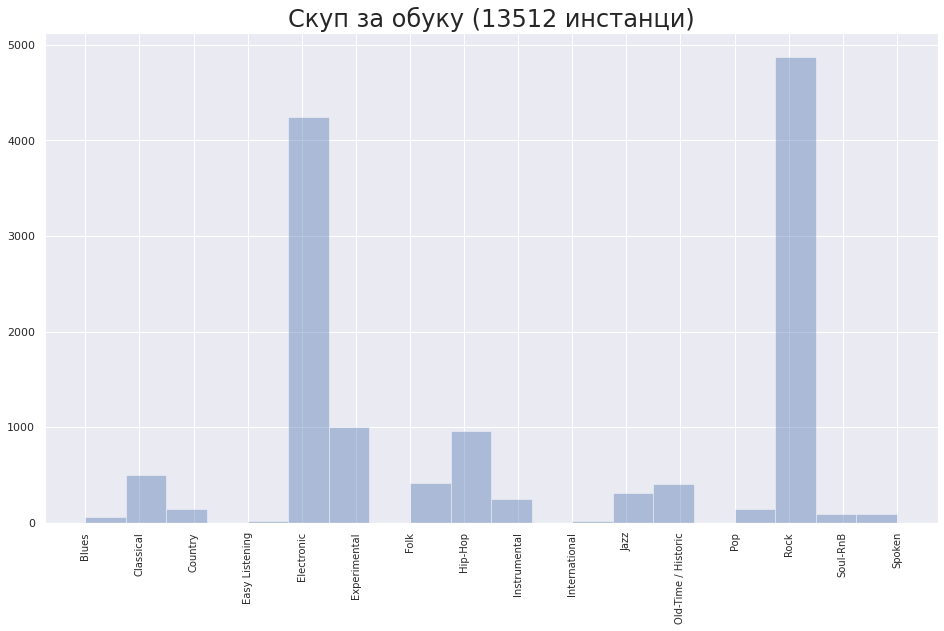

In [45]:
plot_class_hist(data_train, 'Скуп за обуку')

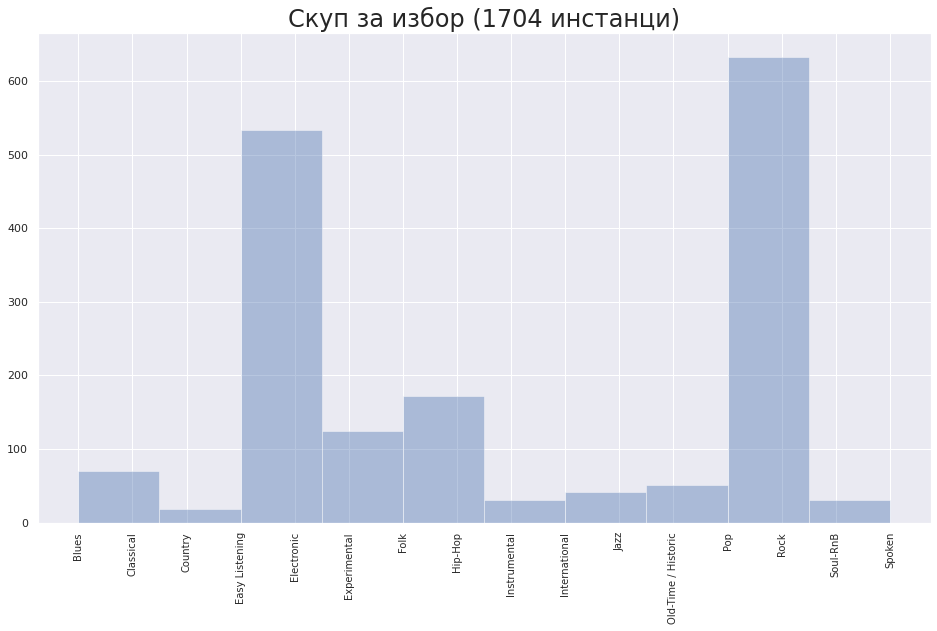

In [46]:
plot_class_hist(data_val, 'Скуп за избор')

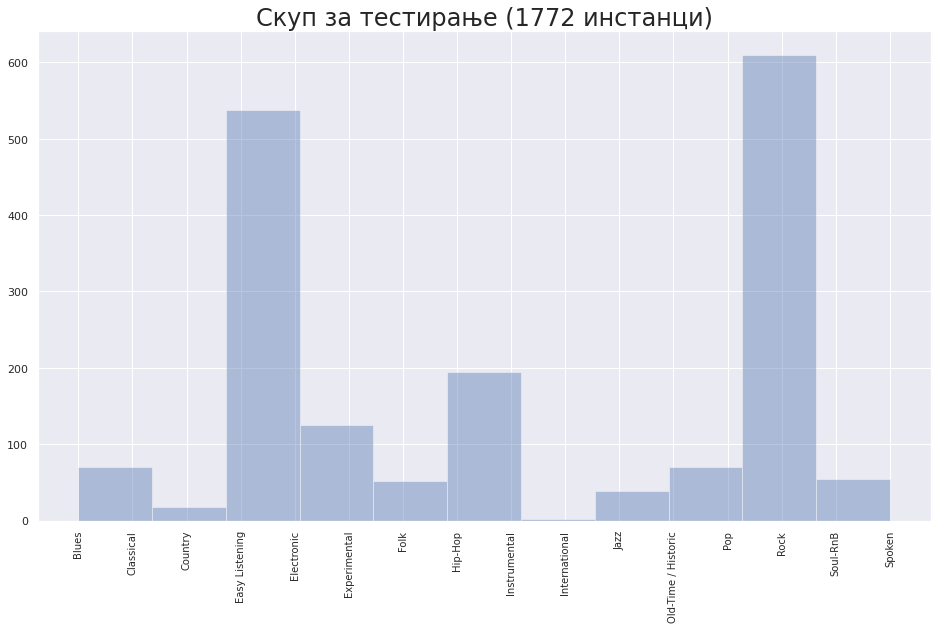

In [47]:
plot_class_hist(data_test, 'Скуп за тестирање')